# Moscow Housing Dataset

In this challenge you will predict the prices of apartments in Moscow. 

Real estate is a popular investment vehicle and can be pretty lucurative. Whether you're an individual looking for a place to call home or an investor looking for a profitable opportunity, being able to appraise assets accurately - or at least better than the next guy - can be of huge value.

We have procured a dataset consisting of information about over 33,000 apartments in Moscow. It contains around 30 variables that encode data such as location, facilities, and building information. Your task is to do analysis, feature engineering, and ultimately create models that can reliably predict the listed price of both low- and high-end apartments.

In [3]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

## 1: Data

We begin this tutorial by showing how you can download the material and giving a description of the data you will be working with.

### Download (with Kaggle API)

The data can be download through the Kaggle API. If you've obtained the data in some other fashion (e.g. by downloading it through the web page) then you can skip this step. Just ensure that all the data is located in a sub-directory of the directory this notebook is located in called `data`. 

To download the data with the Kaggle API, you'll need the _API client_ and an _API key_. Full documentation on how to use it is available from [the official github repository](https://github.com/Kaggle/kaggle-api), but an abriged version is given below.

The client can be installed through pip/anaconda.

```bash
pip install kaggle
conda install -c conda-forge kaggle
```

The API key can be generated from the kaggle website. Go to `Your Profile` (in sidebar accessible from icon in the top right corner), navigate to the `Account` tab, scroll down to the `API` section, and click the `Create New API Token` button. This should generate an API token and start a download of a json file called `kaggle.json`. 

Once the download is complete, you must move the file to a special kaggle folder.


```bash
mkdir -p ~/.kaggle   # Creates a '.kaggle' directory in your homefolder if it doesn't exist
mv ~/Downloads/kaggle.json ~/.kaggle   # Moves 'kaggle.json' (API key) to ~/.kaggle folder
chmod 600 ~/.kaggle/kaggle.json  # Sets read/write access to API key file to owner only
```

**Note**: on Windows, the default location for the kaggle home folder might look something like `C:\Users\<Windows-username>\.kaggle\kaggle.json`.

Once the API is set up you can download the competition data.

In [11]:
# -- Uncomment and run the shell commands below to download and unzip

# # Create a data folder (if it does not exist)
# !mkdir -p ./data 
# # Download the competition data as a zip
# !kaggle competitions download -c moscow-housing-tdt4173 -p ./data/ 
# # Unzip the competition data (alternatively use another unzipping software you have installed)
# !unzip -o -d data/ data/moscow-housing-tdt4173.zip

# -- Here we just create a symlink because this code is being run on a kaggle 
#    machine where the data is already downloaded to /kaggle/input/...

# Note: Don't run this command if you run this notebook locally
!ln -s /kaggle/input/moscow-housing-tdt4173 ./data

### Directory structure

The dataset comes as 6 files plus a street map of moscow. We will have a closer look at the data later, but a brief rundown of the contents is given below.

- `apartments_(train|test).csv` contains information about specific apartments. Each row in this table corresponds to one datapoint that you will make a prediction for. The train file also contains a column for the listed apartment price, i.e. the ground truth to the variable you will be predicting.
- `buildings_(train|test).csv` contains suplementary information about the building each apartment is located in. 
- `(apartments|buildings)_meta.json` contains metadata about the columns found in the apartment and building tables, including a brief description, the datatype, and categories (where applicable).

In [2]:
!ls ./data | sort

apartments_meta.json
apartments_test.csv
apartments_train.csv
buildings_meta.json
buildings_test.csv
buildings_train.csv
moscow.png


In [5]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

### Appartments

We first load the training split of the apartment data. This file contains information that is specific to each apartment. As previously stated, each row in this table correspond to a unique datapoint and the price column is the variable you will be trying to predict in this challenge. We use the `describe_data` function decleared in the cell above to map the apartment data to its metadata and generate summary statistics. Note that several of the features have a substantial amount of missing values (`#NaN`). We will get back to this later in this notebook.

In [14]:
apartments = pd.read_csv('data/apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


### Buildings

Next we load the training split of the building data. In it, you will find additional building-level information to supplement the apartment data. This includes its physical location, its current state and construction details, as well as shared facilities such as elevators and parking. This file is a bit smaller than the apartment file because several apartments can map to the same building. As we will see in the next section, you can use the `id` column to map buildings to their respective apartments.

In [13]:
buildings = pd.read_csv('data/buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('data/buildings_meta.json') as f: 
    buildings_meta = json.load(f)
buildings.head()
describe_data(buildings, buildings_meta)

Loaded 6791 buildings


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID of building for joining with apartments,#unique=6791
new,boolean,227,Whether it is an old or new building,"False(6141), True(423)"
latitude,real,0,Latitude coordinate of building,"mean=55.7, std=0.1, min=55.2, max=56.0"
longitude,real,0,Longitude coordinate of building,"mean=37.6, std=0.2, min=36.9, max=38.0"
district,categorical,1,Administriative district within Moscow,"Central(637), East(956), North(593), North-East(630), North-West(553), Novomoskovsk(344), South(758), South-East(672), South-West(900), Troitsk(146), West(535), Zelenograd(66)"
street,string,0,Bulding street name,#unique=1682
address,string,0,Building address (within street),#unique=1851
constructed,integer,479,Year when the building was constructed,"mean=1985.8, std=24.3, min=1855.0, max=2023.0"
material,categorical,1165,Primary building material used in building,"Block(679), Bricks(1226), Monolith(1312), Monolithic_brick(19), Panel(2384), Stalin_project(2), Wood(4)"
stories,integer,0,Total number of floors in the building,"mean=13.0, std=7.0, min=1.0, max=95.0"


## Combined

Most datascience tools and pipelines for tabular data assumes a single table (sometimes referred to as a design matrix) to work with. To supplement the apartment datapoints with building information, we map building rows to apartment rows based on the `apartment.building_id == building.id` relationship with the `pd.merge` function. We use a `left` join to preserve all the apartment rows, while possibly duplicating building rows that correspond to more than one apartment.

In [15]:
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data.head()

All apartments have an associated building: True


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


## 2: Objective

Your objective is to predict the value of the `price` column based on all the other columns. You are free to approach this regression problem with all the data science tricks you know or learn about during the project, just make sure that your process is well-documented and explained in your deliverables.

### Evaluation Metric

It is common to evaluate regression problems according to some deviation measure of the error (difference) between the predictions and the ground truth values. Typical choices are Mean Squared Error (MSE) and its square root, the Root Mean Squared Error (RMSE). 

However, both of these measures are quite sensitive to extreme values and work best if the typical scale of prediction errors are consistent across the dataset. This is not likely to be the case here because the price variable ranges from around 1 million rubles to over 2 billion rubles. This means that a, say 10%, prediction error would matter a lot more if it is for one of the expensive apartments than if it is for one of the cheaper ones. Consequently, we will use a variation that takes a log transform of the target variable before computing prediction errors.

**TL;DR**: submissions for this problem will be evaluated according to the `Root Mean Squared Log Error` (RMSLE):

- $\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n}{(\log(1 + \hat{y_i}) - \log(1 + y_i))^2}}$

In the equation above, ${y_i}$ corresponds to the ground truth for datapoint $i$, $\hat{y_i}$ corresponds to the predicted value for datapoint $i$, and $n$ denotes the total number of datapoints (size of $y$, $\hat{y}$). See the cell below for an implementation.

In [21]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

### Train-Test Split

We have already made a train/test split that will be used to evaluate your submission. Concretely, you are given:
- ~23k training samples **with** price data that you can use to select and fit models
- ~10k testing samples **without** price data that we will use to evaluate your models

The split have been desiged so that you can expect roughly the same distribution of data during evaluation. Specifically, we have made sure to stratify it with respect to the price range and location of apartments. In the cell below, we load the test split in an equivalent manner to how the training data was loaded.

In [16]:
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.head()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


## 3: Basic Exploratory Data Analysis (EDA)

In the sections below, we provide brief analyses of some of the more pertient aspects of the data. Doing good EDA is an artform in itself and we expect you to go beyond what is provided here.

### Missing Data

We begin by taking a closer look at the missing values. As can be seen in the plots below, about half of the features have almost no missing values, but the remainig half is a mixed bag ranging from around 20% missing values to more than 70%. For [various reasons](https://en.wikipedia.org/wiki/Missing_data#Types), this is a common problem setting in machine learning that can be tackled in several ways. Perhaps the easiest way to go about it is to simply ignore all features with missing values. However, that naturally comes with the risk of missing out on useful information that could benefit the model. You can also drop rows with missing values from the training set, but remember that you still have to make predictions for all the rows in the test set.

The process of filling in missing data entries is referred to as _imputation_. A simple way to do this for real-valued data is to replace missing values by the sample mean (or median) of the data that is present. For categorical features, you can create an extra category for "missing", and boolean features can be converted to a categorical True/False/DontKnow. However, there are also more sophisticated approaches out there that you might want to look into. For more information on the topic, [Scikit Learn's documentation](https://scikit-learn.org/stable/modules/impute.html) is a good place to start.

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


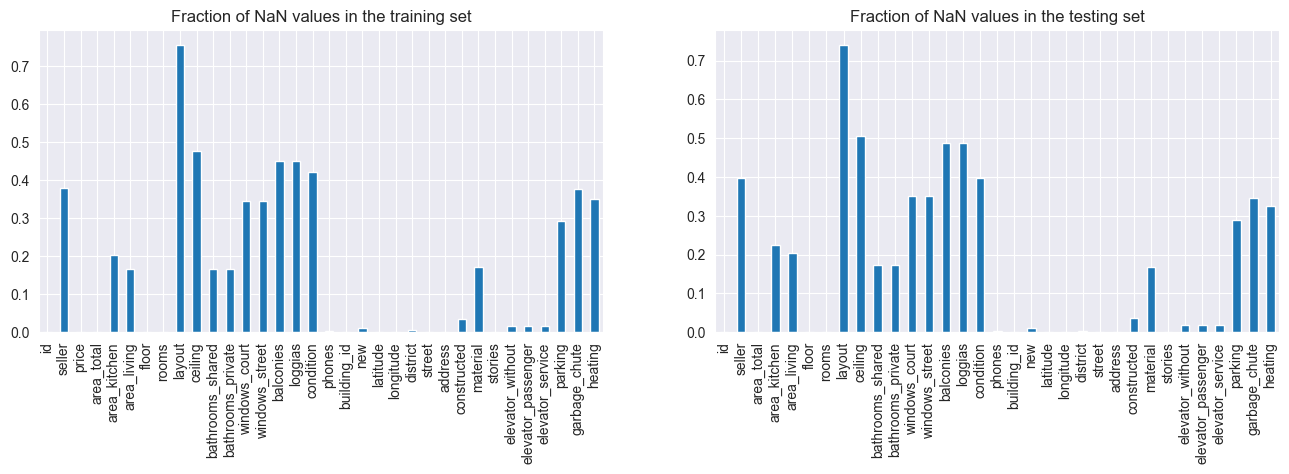

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data.price.isna().sum()}')
print(f'Training set features with any missing value: {data.isna().any().sum()}/{data.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

### Regression Target

Next we examine the target variable; the listed apartment price. As previously mentioned, there's a big spread in prices. Plotting a histogram of the raw value yields a sharp peak (relatively) close to zero with a long tail stretching past 2.5 billion rubles. A log transform makes it a bit easier to tell what is going on. We use a `log10` transform so that the number on the x-axis correspond to the number of digits in the price. A distinct mode can be observed around 7.0 (10 million rubles) with the distribution tapering off quickly to the left and more slowly to the right.

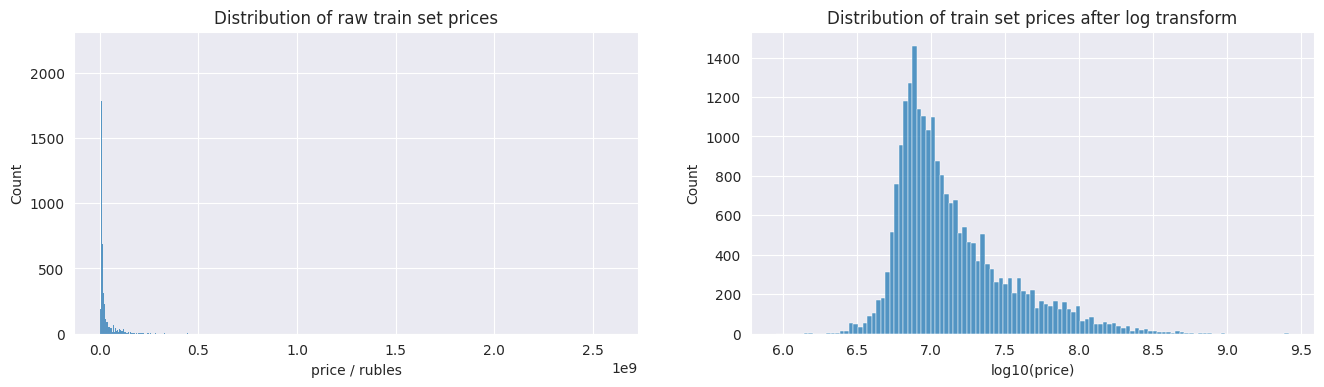

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(data.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices');
sns.histplot(np.log10(data.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');

### Geographical Considerations

Here we will have a rudimentary look at correlations between features and the target variable. Specifically, we will investigate the relationship between an apartment's location and its price. Anyone who's ever been out apartment shopping knows that proximity to popular facilities often plays a huge role in what prices you should expect. We visualize the relationship by creating a scatterplot between the latitude and longitude coordinate features and colorcode the dots based on the apartment price. To further contextualize the data, we also add a backdrop of Moscow exported from [Open Street Map](https://www.openstreetmap.org/#map=10/55.7515/37.4998).

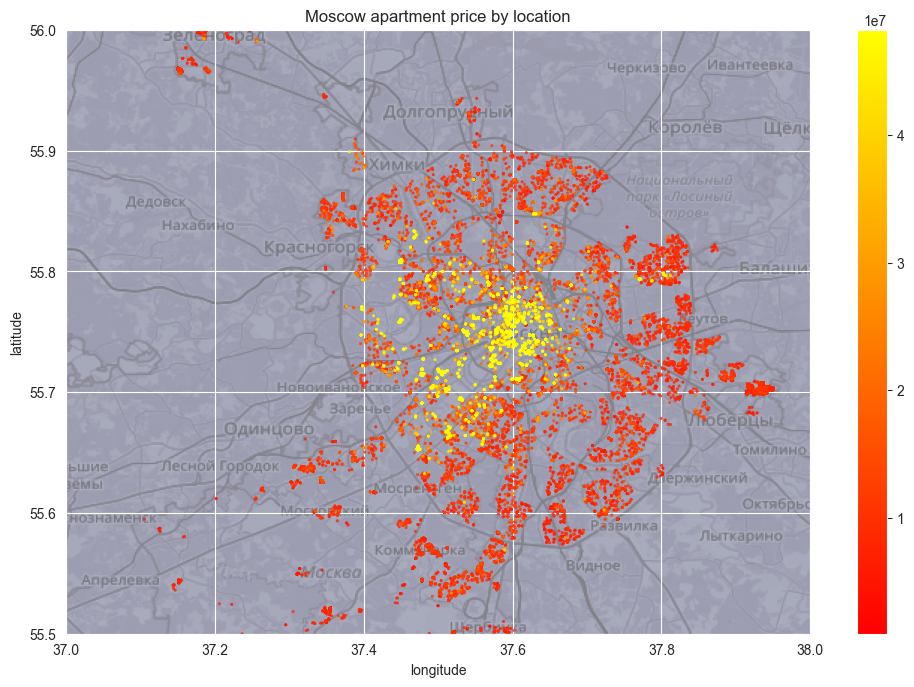

In [23]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(data);

## 4: Getting Started

To conclude this demo, we will give quick rundown of how you can split the dataset to do your own evaluations, train simple models, and create a submission with predictions that can be uploaded to Kaggle/Blackboard.


### Validation Split

Even though you can get feedback on how well you're doing by uploading submissions to Kaggle, it a lot quicker to do it yourself. Creating an evaluation split allows you to estimate the out-of-sample performance of your models and is particularly useful when (e.g.) testing out a new preprocessing pipeline or optimizing hyperparameters. In the following cell, we split the training data into two subpartitions with 67% data in the training set and 33% data in the validation set. 

Note that we stratify based on (rounded) log price. This ensures that we get roughly the same price distributions in both the training and validation set (see figures).

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

Split dataset into 15600 training samples and 7685 validation samples


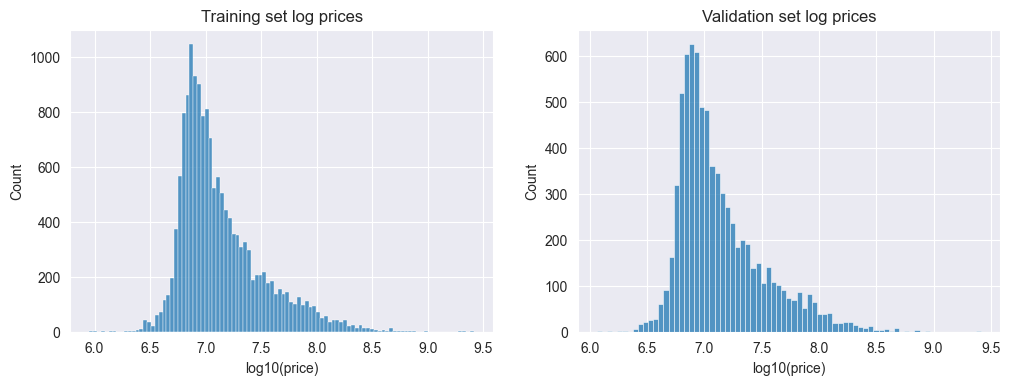

In [18]:
import sklearn.model_selection as model_selection

data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, dpi=100)
print(f'Split dataset into {len(data_train)} training samples and {len(data_valid)} validation samples')

sns.histplot(np.log10(data_train.price).rename('log10(price)'), ax=ax1);
sns.histplot(np.log10(data_valid.price).rename('log10(price)'), ax=ax2);
ax1.set_title('Training set log prices'); ax2.set_title('Validation set log prices');

### A very simple Baseline

It is useful to establish where the floor is, performance-wise, before starting to hypothesising about what the best features and models should look like. Here we create a simple mean predictor and obtain an RMSLE of around 1.02, both in- and out-of-sample. Any model that is conditioned on features should perform better than this benchmark.

**Challenge**: Can you make a different "constant value predictor" that performs better than the sample mean with respect the the RMSLE metric used? The solution to this problem could be useful when defining the objective/loss of more complex models.

In [15]:
y_train = data_train.price
y_valid = data_valid.price

mean = y_train.mean()
y_train_hat = np.full(len(y_train), mean)
y_valid_hat = np.full(len(y_valid), mean)

print(f'Train rmsle: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

Train rmsle: 1.0215
Valid rmsle: 1.0223


### Spatial Decision Tree

Next we will try to make a slightly more sophisticated model. The EDA above suggests that you can make a nontrivial guess about prices based on geographical location alone. We, therefore, train a model to make price predictions conditioned on the latitude and longitude of the listed apartment. We use a [Regression Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) (Decision Tree for real valued output) and fit it with default hyperparameters.

It can be observed that this leads to a substantial improvement in performance. Although we overfit a bit, the validation RMSLE is more than halved compared to the mean-predicting baseline. 

Train RMSLE: 0.2769
Valid RMSLE: 0.4210


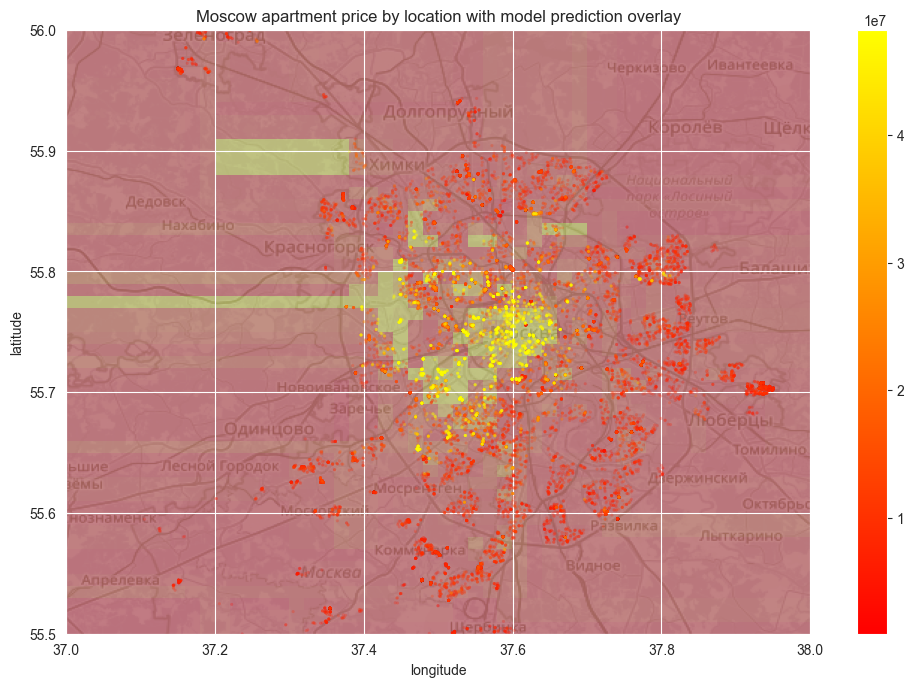

In [24]:
import sklearn.tree as tree

X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price

model = tree.DecisionTreeRegressor().fit(X_train, y_train)

y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

lats, lngs = np.meshgrid(np.linspace(55.5, 56, 50), np.linspace(37, 38, 50))
preds = model.predict(np.stack([lats, lngs], axis=-1).reshape(-1, 2)).reshape(lats.shape)
ax, norm = plot_map(data, a=0.25)
ax.set_title(ax.get_title() + ' with model prediction overlay')
ax.imshow(preds.T[::-1, :], extent=(37, 38, 55.5, 56), alpha=0.3, aspect='auto', cmap='autumn', norm=norm);

### Sample Submission

Lastly, we'll demonstrate how to make a submission. We begin by training another Decision Tree Regressor just like in the section above, except this time over the entire training set. 
The trained model is then used to generate predictions for the test set. Note that we invoke a little bit of trickery here. The test set is missing latitude/longitude coordinates for two datapoints, so we take the easy route and only generate predictions for the remaining 9935 entries. The two remaining predictions are simply filled with the mean price.
In the end, we export the predictions to a .csv file. Its format is pretty simple; one row for each datapoint and each row contains the id of the predicted datapoint along with the predicted price. 

**Important**: make sure that the id column of your submission file matches the id of `apartments_test.csv` and that the header used is `id,price_prediction`.

The exported .csv file can then be submitted to kaggle and bundled with your final delivery on blackboard.

In [25]:
# Fit model to the full dataset 
X_train = data[['latitude', 'longitude']]
y_train = data['price']
print(f'Num nans in train {X_train.isna().any(axis=1).sum()}')
model = tree.DecisionTreeRegressor(max_depth=20).fit(X_train, y_train)

# Generate predictions for test set 
X_test = data_test[['latitude', 'longitude']]
X_test_nan = X_test.isna().any(axis=1)
print(f'Num nans in test: {X_test_nan.sum()}')
y_test_hat = model.predict(X_test[~X_test_nan])

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission.loc[~X_test_nan, 'price_prediction'] = y_test_hat # Predict on non-nan entries
submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('sample_submission.csv', index=False)

# Look at submitted csv
print('\nLine count of submission')
!wc -l sample_submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 sample_submission.csv

Num nans in train 0
Num nans in test: 2
Generated 9937 predictions

Line count of submission
    9938 sample_submission.csv

First 5 rows of submission
id,price_prediction
23285,77846153.6923077
23286,8440000.0
23287,6799644.869565218
23288,10100000.0


### Uploading restults

Once a submission csv has been created it can be uploaded to Kaggle. You can upload sumbissions manually through the competition web page ([as explained here](https://www.kaggle.com/docs/competitions#submitting-predictions)). Alternatively, you can use the Kaggle API and do it from the terminal with the following command template:

```bash
kaggle competitions submit moscow-housing-tdt4173 -f <filepath> -m "<message>"
```

Where `<filepath>` in this case would be `./sample_submission.csv` and `<message>` is your own comment for the submission.

The submission created here was actually used as the sample submission in the Kaggle competition. You should be able to find it in the leaderboard under the team name `sample_submission.csv`. It obtained a **public**$^1$ score of 0.61666. Note that this is quite a bit higher than the 0.4326 validation set score we obtained above, but it is actually not that surprising given the way this model work (hint: analyze building IDs across train/test).

$^1$) The kaggle leaderboard will display your public score. For this competition, this constitutes RMLSE calcluated over a sub-sample of the test set (50% of the data). Your score for the remaining test set datapoints will remain hidden until the end of the competition. The reason for this is the same reason that you typically want to do a train/valid/test split in machine learning. If complete feedback on all the test samples were constantly available, then you could more easily overfit you models (in terms of hyperparamters, ensemble composition, etc).